In [1]:
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
from torch.utils.data import DataLoader

from score_models.trainer import trainer
from score_models.models.mlp.mlp import MLPScoreModel
from score_models.train_steps.ncsn_train_steps import TrainStepNCSN
from score_models.utils.data import guassian_mixture
from score_models.utils.noise import get_sigmas
from score_models.utils.visualisations import plot_gradient_field
from score_models.sampling import annealed_langevin_dynamics

In [2]:
# load dataset
dataset = guassian_mixture(N=10_000)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

In [3]:
device = "cuda"
input_size = 2
hidden_size = 32
L = 10
lr = 1e-4

# define score model and optimizer
score_model = MLPScoreModel(input_size=input_size, hidden_size=hidden_size, T=L).to(device)
optimizer = optim.Adam(score_model.parameters(), lr=lr)

# define train step (i.e., criterion)
sigma_min, sigma_max = 1.0, 20.0
sigmas = get_sigmas(L=L, sigma_min=sigma_min, sigma_max=sigma_max)
train_step = TrainStepNCSN(score_model=score_model, sigmas=sigmas)


In [4]:
score_model = trainer(
    train_step=train_step,
    model=score_model,
    train_loader=dataloader,
    optimizer=optimizer,
    num_steps=20000,
    log_every=2000,
    save_every=5000,
    batch_preprocessor=lambda x: (x.to(device), ),
)

  0%|          | 31/20000 [00:00<03:52, 85.76it/s] 

Step 1, Loss: 55.0882


 10%|█         | 2048/20000 [00:07<00:56, 316.37it/s]

Step 2000, Loss: 0.9243


 20%|██        | 4054/20000 [00:13<00:50, 314.70it/s]

Step 4000, Loss: 0.7775


 30%|███       | 6042/20000 [00:19<00:42, 326.66it/s]

Step 6000, Loss: 0.6854


 40%|████      | 8063/20000 [00:25<00:37, 318.26it/s]

Step 8000, Loss: 0.6134


 50%|█████     | 10048/20000 [00:32<00:32, 308.10it/s]

Step 10000, Loss: 0.5691


 60%|██████    | 12042/20000 [00:38<00:25, 314.46it/s]

Step 12000, Loss: 0.5798


 70%|███████   | 14045/20000 [00:45<00:20, 291.19it/s]

Step 14000, Loss: 0.5666


 80%|████████  | 16034/20000 [00:51<00:13, 303.49it/s]

Step 16000, Loss: 0.5204


 90%|█████████ | 18032/20000 [00:58<00:06, 304.46it/s]

Step 18000, Loss: 0.4991


100%|██████████| 20000/20000 [01:05<00:00, 307.33it/s]


Step 20000, Loss: 0.5757


In [5]:
# sample some datapoints
x = torch.rand(500, 2).to(device)
samples = annealed_langevin_dynamics(
    x=x,
    score_model=score_model, 
    sigmas=sigmas, 
    T=100,
    eps=0.1,
).cpu().numpy()

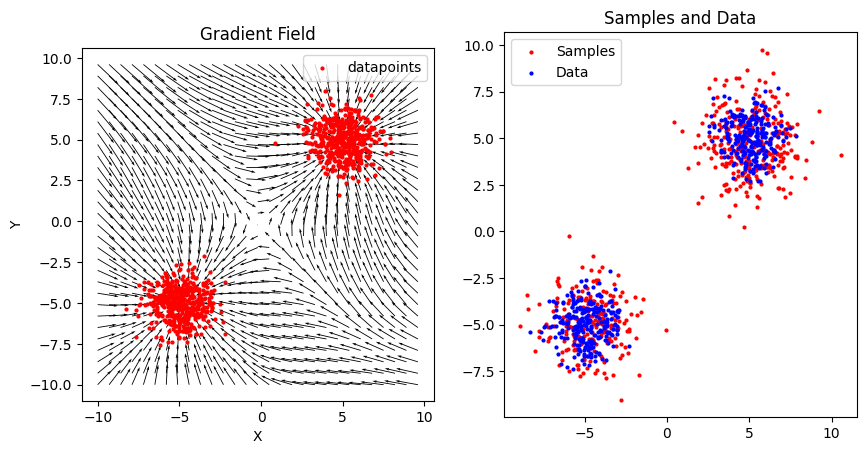

In [6]:
_, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# plot gradient field
plot_gradient_field(score_model=score_model, i=L-1, datapoints=dataset[:1000], ax=ax[0])

# plot original data and samples
ax[1].scatter(samples[:, 0], samples[:, 1], color='red', s=4, label='Samples')
ax[1].scatter(dataset[:500][:, 0], dataset[:500][:, 1], color='blue', s=4, label='Data')
ax[1].set_title('Samples and Data')
plt.legend();